In [5]:
from scipy.special import jv
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline
plt.rcParams["mathtext.fontset"] = "cm"

## Parameters

||Density $$(\text{kg}\cdot\text{m}^{-3})$$|Shear modulus $$(\text{Pa})$$|
|:---:|:---:|:---:|
|Carbon|$1750$|$8.847\times 10^{10}$|
|Epoxy|$1200$|$1.615\times 10^9$|
|Aluminium|$2697$|$2.79\times 10^{10}$|
|Nickel|$8936$|$7.54\times 10^{10}$|

* Lowering $N$ and $acc$ will increase the speed of calculation in the price of accuracy

rho matrix done...
tau matrix done...
M to Γ path done...
Γ to X path done...


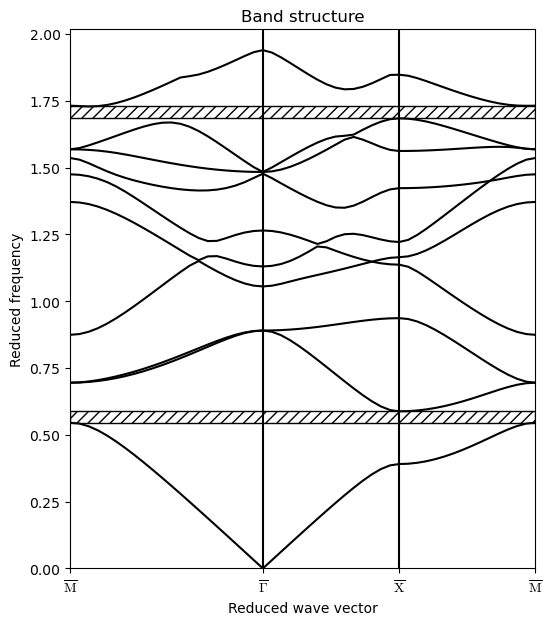

Execution time: 27.927603006362915 s


In [6]:
f = 0.6  # fraction of cylinder in the cell
N = 8 # Truncation index, where |n_x|<=N, |n_y|<=N
acc = 15
a = 1  # side length of the lattice
Filling_shear = 7.54e10  # rho*c_t^2 of filling material in SI unit
Background_shear = 2.79e10  # rho*c_t^2 of background material in SI unit
Filling_density = 8936  # density of filling material in SI unit
Background_density = 2697  # density of background material in SI unit


start_time = time.time()
G_vec = np.empty((0, 2))
for i in range(-N, N+1):
    for j in range(-N, N+1):
        G_vec = np.vstack((G_vec, np.array([2*np.pi/a*i, 2*np.pi/a*j])))


r = (a*a*f/np.pi)**(1/2)
rho_matrix = np.zeros(((2*N+1)**2, (2*N+1)**2))
for i in range((2*N+1)**2):
    for j in range((2*N+1)**2):
        vec = G_vec[i]-G_vec[j]
        if vec[0] == 0 and vec[1] == 0:
            rho = Filling_density*f+Background_density*(1-f)
            rho_matrix[i][j] = rho
        else:
            G = vec
            G = (G.dot(G)) ** (1 / 2)
            rho = 2*(Filling_density-Background_density)*f*jv(1, G*r)/(G*r)
            rho_matrix[i][j] = rho

rho_matrix_inverse = np.linalg.inv(rho_matrix)
print('rho matrix done...')
tau_matrix = np.zeros(((2 * N + 1) ** 2, (2 * N + 1) ** 2))
for i in range((2 * N + 1) ** 2):
    for j in range((2 * N + 1) ** 2):
        vec = G_vec[i] - G_vec[j]
        if vec[0] == 0 and vec[1] == 0:
            tau = 1 / Filling_shear * f + 1 / Background_shear * (1 - f)
            tau_matrix[i][j] = tau
        else:
            G = vec
            G = (G.dot(G)) ** (1 / 2)
            tau = 2 * (1 / Filling_shear - 1 / Background_shear) * f * jv(1, G * r) / (G * r)
            tau_matrix[i][j] = tau

tau_matrix_inverse = np.linalg.inv(tau_matrix)
print('tau matrix done...')


omega = np.empty((0, 10))
for i in range(round(acc*1.414)):
    kx = np.pi/a-np.pi/a*i/round(acc*1.414)
    ky = np.pi/a-np.pi/a*i/round(acc*1.414)
    tau_k = np.empty((0, (2 * N + 1) ** 2))
    for j in range((2 * N + 1) ** 2):
        tau_row = np.array([])
        for k in range((2 * N + 1) ** 2):
            taug = tau_matrix_inverse[j][k]*(kx**2+(G_vec[j][0] + G_vec[k][0])*kx+(G_vec[j][0] * G_vec[k][0] + G_vec[j][1] * G_vec[k][1])+ky**2+(G_vec[j][1] + G_vec[k][1])*ky)
            tau_row = np.append(tau_row, taug)
        tau_k = np.vstack((tau_k, tau_row))
    multiplied = np.dot(rho_matrix_inverse, tau_k)
    eigenvalues = np.linalg.eigvals(multiplied)
    eigenvalues.sort()
    omega_row = np.array([])
    for i in range(10):
        omega_row = np.append(omega_row, eigenvalues[i]**(1/2))
    omega = np.vstack((omega, omega_row))

print("M to Γ path done...")

for i in range(acc):
    kx = np.pi/a*i/acc
    ky = 0
    tau_k = np.empty((0, (2 * N + 1) ** 2))
    for j in range((2 * N + 1) ** 2):
        tau_row = np.array([])
        for k in range((2 * N + 1) ** 2):
            taug = tau_matrix_inverse[j][k]*(kx**2+(G_vec[j][0] + G_vec[k][0])*kx+(G_vec[j][0] * G_vec[k][0] + G_vec[j][1] * G_vec[k][1])+ky**2+(G_vec[j][1] + G_vec[k][1])*ky)
            tau_row = np.append(tau_row, taug)
        tau_k = np.vstack((tau_k, tau_row))
    multiplied = np.dot(rho_matrix_inverse, tau_k)
    eigenvalues = np.linalg.eigvals(multiplied)
    eigenvalues.sort()
    omega_row = np.array([])
    for i in range(10):
        omega_row = np.append(omega_row, eigenvalues[i]**(1/2))
    omega = np.vstack((omega, omega_row))

print("Γ to X path done...")

for i in range(acc):
    kx = np.pi/a
    ky = np.pi/a*i/acc
    tau_k = np.empty((0, (2 * N + 1) ** 2))
    for j in range((2 * N + 1) ** 2):
        tau_row = np.array([])
        for k in range((2 * N + 1) ** 2):
            taug = tau_matrix_inverse[j][k]*(kx**2+(G_vec[j][0] + G_vec[k][0])*kx+(G_vec[j][0] * G_vec[k][0] + G_vec[j][1] * G_vec[k][1])+ky**2+(G_vec[j][1] + G_vec[k][1])*ky)
            tau_row = np.append(tau_row, taug)
        tau_k = np.vstack((tau_k, tau_row))
    multiplied = np.dot(rho_matrix_inverse, tau_k)
    eigenvalues = np.linalg.eigvals(multiplied)
    eigenvalues.sort()
    omega_row = np.array([])
    for i in range(10):
        omega_row = np.append(omega_row, eigenvalues[i]**(1/2))
    omega = np.vstack((omega, omega_row))

c = ((Filling_shear*f+Background_shear*(1-f))/(Filling_density*f+Background_density*(1-f)))**(1/2)
omega = omega*a/2/np.pi/c
omega = omega.real
omega = np.vstack((omega, omega[0]))

omegat = np.transpose(omega)

fig, ax = plt.subplots(figsize=(6, 7))

ax.set_xlabel('Reduced wave vector')
ax.set_ylabel('Reduced frequency')
plt.xlim(-2**(1/2)*np.pi/a, 2*np.pi/a)
ax.set_xticks([-2**(1/2)*np.pi/a, 0, np.pi/a, 2*np.pi/a])
ax.set_xticklabels([r'$\overline{\mathrm{M}}$', r'$\overline{\Gamma}$', r'$\overline{\mathrm{X}}$', r'$\overline{\mathrm{M}}$'])
plt.ylim(0, 1.04*np.max(omegat[-1]))
ax.plot([0, 0], [0, 100], c='black')
ax.plot([np.pi/a, np.pi/a], [0, 100], c='black')
plt.title('Band structure')


for i in range(10):
    ax.plot(np.linspace(-2**(1/2)*np.pi/a, 0, round(acc*1.414)+1), omegat[i][:round(acc*1.414)+1], c='black')
    ax.plot(np.linspace(0, np.pi/a, acc+1), omegat[i][round(acc*1.414):round(acc*1.414)+acc+1], c='black')
    ax.plot(np.linspace(np.pi/a, 2*np.pi/a, acc+1), omegat[i][round(acc*1.414)+acc:], c='black')


# band gap
gap = np.array([])
for i in range(len(omegat)-1):
    max = np.max(omegat[i])
    min = np.min(omegat[i+1])
    if max < min:
        gap = np.append(gap, max)
        gap = np.append(gap, min)
for i in range(0, len(gap), 2):
    lower = gap[i]
    upper = gap[i+1]
    ax.fill_between([-2 ** (1 / 2) * np.pi / a, 2 * np.pi / a], lower, upper, color='none', hatch='///',
                    edgecolor='black')

plt.show()
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} s")